# Plant core genes lost with parasitism

## Method

* Orthologous Groups were inferred using [SonicParanoid2](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-024-03298-4) (graph-based only)

## Dataset

* 5 hemi-parasitic plants
* 5 holo-parasitic plants
* 18 non-parasitic plant (One per order of the Pentapetalae)

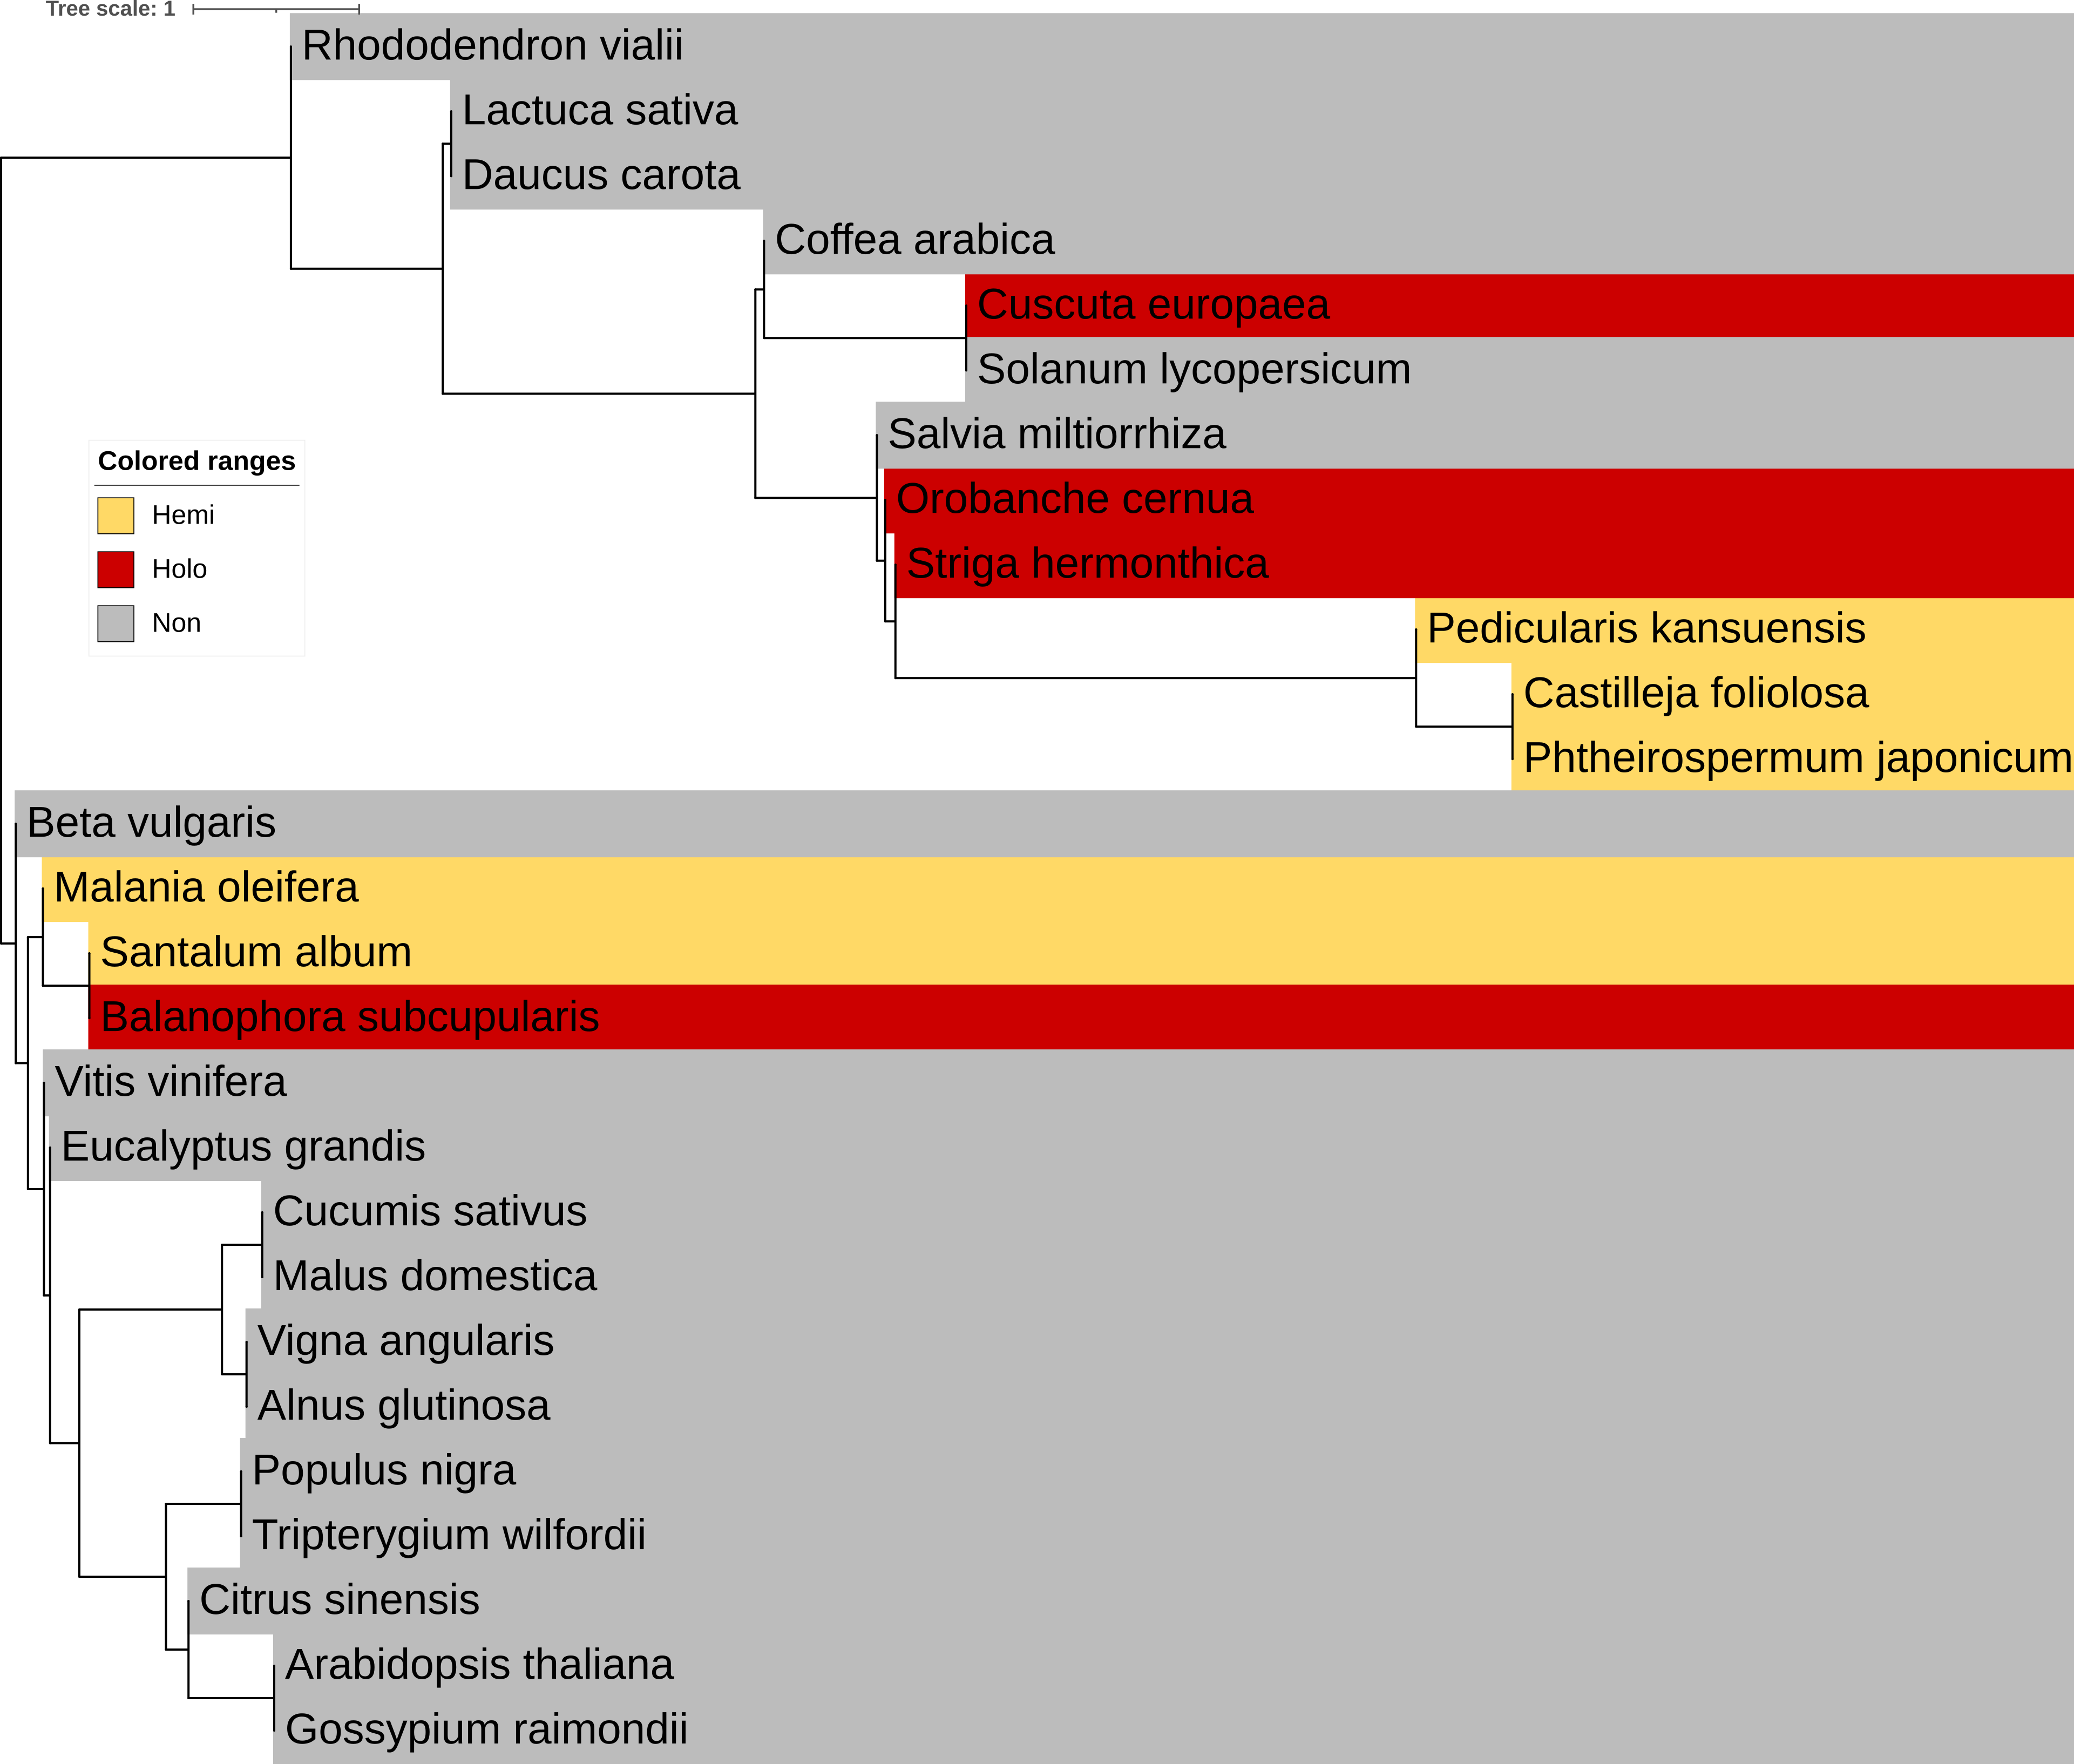

In [15]:
from IPython.display import Image

fig = Image(filename=('28_parasiticplants_tree.png'), width=800)
fig

**Figure:** Phylogenetic tree of 10 parasitic and 18 non-parasitic plants. Pruned from [Zuntini et al. 2024, Nature](https://www.nature.com/articles/s41586-024-07324-0)

# Phylogenetic profile of lost core genes

Orthologous groups (OGs) of (non-parasitic) plant core genes are shown in the rows. The 28 plant taxa considered in this analysis are shown in the columns.

Non-parasitic plants are shown in blue, hemi-parasitic plants are shown in grey, and holo-parasitic plants are shown in yellow.

The hoverover information displays the protein_ids assigend to the OG in the corresponding plant species. Additionally, the functional annotation of the ortholog in _A. thaliana_ is shown.

### Parameters

* **Core factor**: Ratio of non-parasitic plants in which a gene must be found to be considered a "core gene"
* **Loss factor**: Ratio of parasitic plants in which a gene must be absent to be considered "lost with parasitism"
* **Annotation**: If "first" show the annotation of the first co-ortholog in _A. thaliana_, if "all" show the annotation of all co-orthologs

In [2]:
# import pandas as pd
# import json
# import plotly.graph_objects as go
# import ipywidgets as widgets
# from IPython.display import display

# from loading import generate_widgets, get_parasets
# from process_core import find_genes_lost_for_parasitism
# from prepare_plotting import prepare_for_heatmap

# # --- widgets ---
# core_factor, loss_factor, propagate_annotation = generate_widgets()
# display(core_factor, loss_factor, propagate_annotation)

# # --- input paths ---
# para_nonpara_overview = f'data/28taxa_overview.tsv'
# og_path = f'data/28taxa_orthogroups.tsv'
# ath_anno_path = 'data/ath_protid2annotation.json'

# # --- load data (once) ---
# taxadf = pd.read_csv(para_nonpara_overview, sep='\t')
# nonparasitic, parasitic, holoparasites, hemiparasites = get_parasets(taxadf)
# column_names = [f'{name}.fa' for name in hemiparasites + holoparasites]

# orthodf = pd.read_csv(og_path, sep='\t')

# with open(ath_anno_path) as fh:
#     ath_protid2annotation = json.load(fh)

# # --- output area for plot ---
# out = widgets.Output()
# display(out)

# # --- function to update the plot ---
# def extract_athaliana_protids(df):
#     print('# NCBI RefSeq Protein IDs of lost core genes in A. thaliana for enrichment analysis:\n')
#     for value in df['Athaliana.fa'].values:
#         if ',' in value:
#             for coortho in value.split(','):
#                 print(coortho)
#         elif value == '*':
#             continue
#         else:
#             print(value)

# def update_plot(change=None):
#     with out:
#         out.clear_output(wait=True)

#         # process data with current widget values
#         loss_overview, lost_orthodf = find_genes_lost_for_parasitism(
#             orthodf,
#             nonparasitic,
#             parasitic,
#             column_names,
#             core_factor=core_factor.value,
#             loss_factor=loss_factor.value
#         )

#         heatmap_df, label_df, anno_df, xlabels, ylabels = prepare_for_heatmap(
#             lost_orthodf,
#             taxadf,
#             ath_protid2annotation,
#             propagate_annotation.value,
#             nonparasitic,
#             hemiparasites,
#             holoparasites
#         )

#         # build heatmap
#         fig = go.Figure(data=go.Heatmap(
#             z=heatmap_df,
#             x=xlabels,
#             y=ylabels,
#             text=label_df,
#             customdata=anno_df,
#             hoverinfo='x+text',
#             hoverongaps=False,
#             showscale=False,
#             type='heatmap',
#             colorscale='Cividis',
#             hovertemplate="<b>%{x}</b><br>%{customdata}<br>%{text}<br><br><extra></extra>",
#         ))

#         # layout
#         row_height = 20
#         height = max(400, row_height * heatmap_df.index.size)
#         fig.update_layout(
#             width=800,
#             height=height
#         )

#         n_rows, n_cols = heatmap_df.shape
#         shapes = []
#         for i in range(1, n_cols):
#             shapes.append(dict(
#                 type="line",
#                 x0=i-0.5, x1=i-0.5,
#                 y0=-0.5, y1=n_rows-0.5,
#                 line=dict(color="white", width=1)
#             ))
#         for j in range(1, n_rows):
#             shapes.append(dict(
#                 type="line",
#                 x0=-0.5, x1=n_cols-0.5,
#                 y0=j-0.5, y1=j-0.5,
#                 line=dict(color="white", width=1)
#             ))

#         fig.update_layout(
#             shapes=shapes,
#             xaxis=dict(showgrid=False),
#             yaxis=dict(showgrid=False, autorange="reversed")
#         )
#         display(fig)


# # --- connect widgets to update ---
# core_factor.observe(update_plot, names="value")
# loss_factor.observe(update_plot, names="value")
# propagate_annotation.observe(update_plot, names="value")

# # --- initial draw ---
# update_plot()


In [10]:
# --- imports ---
import pandas as pd
import json
import plotly.graph_objects as go
import ipywidgets as widgets
from IPython.display import display
import traceback

from loading import generate_widgets, get_parasets
from process_core import find_genes_lost_for_parasitism
from prepare_plotting import prepare_for_heatmap

# --- widgets ---
core_factor, loss_factor, propagate_annotation = generate_widgets()
controls = widgets.VBox([widgets.HBox([core_factor, loss_factor]), propagate_annotation])
display(controls)

# --- small status / log area ---
status = widgets.HTML(value="")
display(status)

# --- input paths ---
para_nonpara_overview = 'data/28taxa_overview.tsv'
og_path = 'data/28taxa_orthogroups.tsv'
ath_anno_path = 'data/ath_protid2annotation.json'

# --- load static data once ---
taxadf = pd.read_csv(para_nonpara_overview, sep='\t')
nonparasitic, parasitic, holoparasites, hemiparasites = get_parasets(taxadf)
column_names = [f'{name}.fa' for name in hemiparasites + holoparasites]

orthodf = pd.read_csv(og_path, sep='\t')
with open(ath_anno_path) as fh:
    ath_protid2annotation = json.load(fh)

# --- helper to convert dataframes/series into nested lists ready for plotly ---
def to_nested_list(df_like):
    # Accept pandas DataFrame or Series or numpy arrays
    try:
        return df_like.values.tolist()
    except Exception:
        return df_like.tolist()

# --- initial processing (synchronous) ---
loss_overview, lost_orthodf = find_genes_lost_for_parasitism(
    orthodf, nonparasitic, parasitic, column_names,
    core_factor=core_factor.value, loss_factor=loss_factor.value
)
heatmap_df, label_df, anno_df, xlabels, ylabels = prepare_for_heatmap(
    lost_orthodf, taxadf, ath_protid2annotation,
    propagate_annotation.value, nonparasitic, hemiparasites, holoparasites
)

# --- prepare arrays for Plotly ---
# z = to_nested_list(heatmap_df)
# text = to_nested_list(label_df)
# customdata = to_nested_list(anno_df)
n_rows, n_cols = heatmap_df.shape


# --- shapes (grid lines) ---
row_height = 20
height = max(400, row_height * n_rows)
shapes = []
for i in range(1, n_cols):
    shapes.append(dict(type="line", x0=i-0.5, x1=i-0.5, y0=-0.5, y1=n_rows-0.5, line=dict(color="white", width=1)))
for j in range(1, n_rows):
    shapes.append(dict(type="line", x0=-0.5, x1=n_cols-0.5, y0=j-0.5, y1=j-0.5, line=dict(color="white", width=1)))

# --- create a FigureWidget (display once) ---
fig_w = go.FigureWidget(
    data=[
        go.Heatmap(
            z=heatmap_df,
            x=xlabels,
            y=ylabels,
            text=label_df,
            customdata=anno_df,
            hoverinfo='x+text',
            hoverongaps=False,
            showscale=False,
            colorscale='Cividis',
            hovertemplate="<b>%{x}</b><br>%{customdata}<br>%{text}<br><br><extra></extra>",
        )
    ]
)
fig_w.update_layout(width=800, height=height, shapes=shapes,
                    xaxis=dict(showgrid=False), yaxis=dict(showgrid=False, autorange="reversed"))

display(fig_w)  # displayed once; subsequent updates mutate this widget in-place

# --- update callback (in-place updates using batch_update) ---
def update_plot(change=None):
    """Compute new heatmap and update the FigureWidget in-place."""
    try:
        status.value = "<i>processing…</i>"
        # compute (may take some time)
        loss_overview, lost_orthodf = find_genes_lost_for_parasitism(
            orthodf, nonparasitic, parasitic, column_names,
            core_factor=core_factor.value, loss_factor=loss_factor.value
        )
        heatmap_df, label_df, anno_df, xlabels, ylabels = prepare_for_heatmap(
            lost_orthodf, taxadf, ath_protid2annotation,
            propagate_annotation.value, nonparasitic, hemiparasites, holoparasites
        )

        z = heatmap_df
        text = label_df
        customdata = anno_df
        n_rows, n_cols = heatmap_df.shape
        height = max(400, row_height * n_rows)

        shapes = []
        for i in range(1, n_cols):
            shapes.append(dict(type="line", x0=i-0.5, x1=i-0.5, y0=-0.5, y1=n_rows-0.5, line=dict(color="white", width=1)))
        for j in range(1, n_rows):
            shapes.append(dict(type="line", x0=-0.5, x1=n_cols-0.5, y0=j-0.5, y1=j-0.5, line=dict(color="white", width=1)))

        # in-place update (single re-render due to batch_update)
        with fig_w.batch_update():
            fig_w.data[0].z = z
            fig_w.data[0].x = xlabels
            fig_w.data[0].y = ylabels
            fig_w.data[0].text = text
            fig_w.data[0].customdata = customdata
            fig_w.layout.height = height
            fig_w.layout.shapes = shapes

        status.value = ""  # clear status
    except Exception:
        status.value = f"<pre>{traceback.format_exc()}</pre>"

# --- wire up observers ---
core_factor.observe(update_plot, names="value")
loss_factor.observe(update_plot, names="value")
propagate_annotation.observe(update_plot, names="value")


HTML(value='')

/home/felixl/mambaforge/envs/DA/lib/python3.11/site-packages/jupyter_client/session.py:721: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



FigureWidget({
    'data': [{'colorscale': [[0.0, '#00224e'], [0.1111111111111111, '#123570'],
                             [0.2222222222222222, '#3b496c'], [0.3333333333333333,
                             '#575d6d'], [0.4444444444444444, '#707173'],
                             [0.5555555555555556, '#8a8678'], [0.6666666666666666,
                             '#a59c74'], [0.7777777777777778, '#c3b369'],
                             [0.8888888888888888, '#e1cc55'], [1.0, '#fee838']],
              'customdata': array([['Ath: ammonium transporter 1;2', 'Ath: ammonium transporter 1;2',
                                    'Ath: ammonium transporter 1;2', ..., 'Ath: ammonium transporter 1;2',
                                    'Ath: ammonium transporter 1;2', 'Ath: ammonium transporter 1;2'],
                                   ['Ath: NAC (No Apical Meristem) domain transcriptional regulator superfamily protein',
                                    'Ath: NAC (No Apical Meristem) domain tr